# Table of Contents

1. [Setup](#Setup)
2. [Isolate ML Features](#Isolate-ML-Features)
3. [PCA Analysis](#PCA-Analysis)
4. [Machine Learning Algorithms](#Machine-Learning-Algorithms)
    1. [Train-Test Split](#Train-Test-Split)
    2. [Sci-kit Learn Models](#Sci-kit-Learn-Models)
    3. [Deep Learning](#Deep-Learning)
    4. [Ensemble Model](#Ensemble Model)
5. [Classifier Scoring](#Classifier-Scoring)
6. [Retrospective Analysis](#Retrospective-Analysis)

# Setup
[Back to Top](#Table-of-Contents)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

# FEATURE_DIR - directory where feature dataframes are saved
DATA_DIR = ROOT_DIR + 'dataframes/'

In [3]:
DF_prest = pd.read_csv(DATA_DIR+'DF_prest_features.csv',index_col = 0)
print 'Number of peptides:', len(DF_prest)

Number of peptides: 45206


Mark all peptides above the mean expression value as "Expressed", and all peptides below as "Not Expressed"

In [4]:
target = 'expressed'
DF_prest.loc[:,target] = DF_prest.conc_cf > DF_prest.conc_cf.mean()

Remove all peptides between the 25th and 75th percentile of expression

In [5]:
min_expressed = np.percentile(DF_prest['conc_cf'],75)
max_not_expressed = np.percentile(DF_prest['conc_cf'],25)

DF_prest_filtered = DF_prest[(DF_prest['conc_cf'] > min_expressed) | (DF_prest['conc_cf'] < max_not_expressed)]

print 'Number expressed:',len(DF_prest_filtered[DF_prest_filtered[target]])
print 'Number not expressed:',len(DF_prest_filtered[DF_prest_filtered[target]==False])
print 'Min expression cutoff:',min_expressed
print 'Max non-expression:',max_not_expressed

Number expressed: 11301
Number not expressed: 11302
Min expression cutoff: 7.2576
Max non-expression: 3.269225


## Isolate ML Features
[Back to Top](#Table-of-Contents)

In [6]:
aa_features = ['list_comp_A','list_comp_R','list_comp_N',
               'list_comp_D','list_comp_C','list_comp_Q','list_comp_E','list_comp_G',
               'list_comp_H','list_comp_I','list_comp_L','list_comp_K','list_comp_M',
               'list_comp_F','list_comp_P','list_comp_S','list_comp_T','list_comp_W',
               'list_comp_Y','list_comp_V',
               # Amino acid types
               'frac_aliphatic', 'frac_aromatic', 'frac_uncharged_polar', 'frac_polar',
               'frac_hydrophobic', 'frac_positive', 'frac_sulfur', 'frac_negative', 'frac_amide',
               'frac_alcohol']

disorder_features = ['disembl_COILS_frac','disembl_REM465_frac','disembl_HOTLOOPS_frac','ronn_avg','ronn_frac',
                    'disopred_avg','disopred_pb_avg','disopred_frac','disopred_pb_frac']

                    
phys_features = ['aa_len',                                        
                # Physical properties
                 'bio_pI','bio_mW','bio_aromaticity','bio_instability','bio_gravy','abs_avg_charge','abs_charge',
                 'avg_charge']
                    
rna_features = ['AAA','AAC','AAT','AAG','ACA','ACC','ACT','ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT',
                'AGG','CAA','CAC','CAT','CAG','CCA','CCC','CCT','CCG','CTA','CTC','CTT','CTG','CGA','CGC',
                'CGT','CGG','TAA','TAC','TAT','TAG','TCA','TCC','TCT','TCG','TTA','TTC','TTT','TTG','TGA',
                'TGC','TGT','TGG','GAA','GAC','GAT','GAG','GCA','GCC','GCT','GCG','GTA','GTC','GTT','GTG',
                'GGA','GGC','GGT','GGG',
                'GC_content','list_nuc_A','list_nuc_C','list_nuc_G','list_nuc_T',
                'GC30',
                # SD sequences
                'sd_like_fwd','sd_like_fwd_frac','sd_like_rev','sd_like_rev_frac','sd_seq_fwd',
                'sd_seq_fwd_frac','sd_seq_rev','sd_seq_rev_frac',
                # RNA folding
                'RNA_folding_energy','RNA_40_energy','tAI']
                    
ss_features = ['acc20_mean','ss_helix', 'ss_ext', 'ss_c', 'ss8_helix', 'ss8_ext', 'ss8_turn', 'ss8_helix3',
               'ss8_pi_helix', 'ss8_bridge', 'ss8_bend', 'ss8_coil', 'acc_frac',
               'in_gravy','out_gravy', 'acc_hydrophilic_in','acc_hydrophilic_out',
               'acc_hydrophobic_in','acc_hydrophobic_out']

list_of_features = aa_features+disorder_features+phys_features+rna_features+ss_features

DF_prest_features = DF_prest_filtered[list_of_features]

In [7]:
len(list_of_features)

148

In [8]:
X = DF_prest_features.values
y = DF_prest_filtered[target].values
n_samples, n_features = X.shape
print("No. of samples = %d" % n_samples)
print("No. of features = %d" % n_features)

No. of samples = 22603
No. of features = 148


In [9]:
DF_prest_features.to_csv(DATA_DIR+'final_ML_features.csv')
DF_prest_filtered[target].to_csv(DATA_DIR+'final_ML_classes.csv')

# PCA Analysis
[Back to Top](#Table-of-Contents)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

print X_pca.shape
print pca.explained_variance_ratio_[:2]

(22603, 148)
[ 0.11884378  0.09766873]


/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


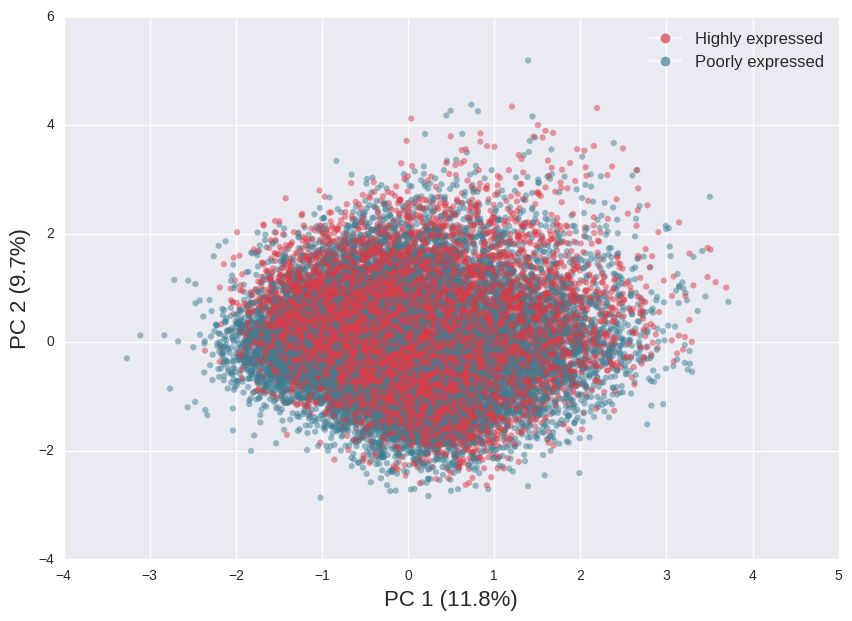

In [11]:
fig,ax = plt.subplots(figsize=(10,7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=cmap)

point1 = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=sns.diverging_palette(220, 10)[-1],alpha=0.7)
point2 = plt.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor=sns.diverging_palette(220, 10)[0],alpha=0.7)

ax.legend((point1,point2),('Highly expressed','Poorly expressed'),fontsize=12)
ax.set_xlabel('PC 1 (11.8%)',fontsize=16)
ax.set_ylabel('PC 2 (9.7%)',fontsize=16)

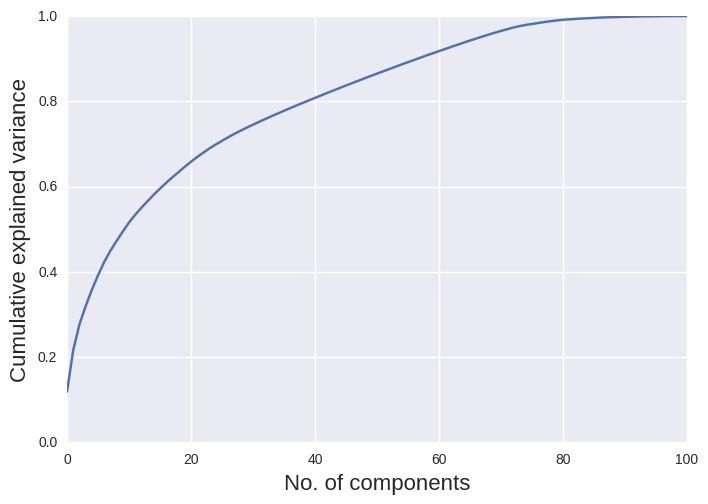

In [12]:
fig,ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_ylim((0,1))
ax.set_xlim((0,100))

ax.set_xlabel('No. of components',fontsize=16)
ax.set_ylabel('Cumulative explained variance',fontsize=16);

# Machine Learning Algorithms
[Back to Top](#Table-of-Contents)

1. [Train-Test Split](#Train-Test-Split)
2. [Sci-kit Learn Models](#Sci-kit-Learn-Models)
3. [Deep Learning](#Deep-Learning)
4. [Ensemble Model](#Ensemble-Model)

### Train-Test Split
[Back to Top](#Machine-Learning-Algorithms)

The data will be split into a 60 - 30 - 10 split between training, testing, and validation sets. After the split, the training data will be scaled to have a mean of 0 and variance 1. This same scaling factor will be applied to the other sets. This ensures that the testing and validation data do not introduce bias in the pre-processing steps.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=.25, random_state=0)

from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
X_val = scl.transform(X_val)


print "Train data shape: %r, Train target shape: %r" % (X_train.shape, y_train.shape)
print "Test data shape: %r, Test target shape: %r" % (X_test.shape, y_test.shape)
print "Validation data shape: %r, Test target shape: %r" % (X_val.shape, y_val.shape)

print "Test-Train-Val Ratio: %.2f-%.2f-%.2f" % (np.true_divide(X_train.shape[0],X.shape[0]),
                                                np.true_divide(X_test.shape[0],X.shape[0]),
                                                np.true_divide(X_val.shape[0],X.shape[0]))


Train data shape: (13561, 148), Train target shape: (13561,)
Test data shape: (6781, 148), Test target shape: (6781,)
Validation data shape: (2261, 148), Test target shape: (2261,)
Test-Train-Val Ratio: 0.60-0.30-0.10


In [14]:
print "Train - Test - Validation data with expressed label:", (y_train==1).sum(),'-',(y_test==1).sum(),'-',(y_val==1).sum()
print "Train - Test - Validation data with not expressed label:", (y_train==0).sum(),'-',(y_test==0).sum(),'-',(y_val==0).sum()

Train - Test - Validation data with expressed label: 6759 - 3439 - 1103
Train - Test - Validation data with not expressed label: 6802 - 3342 - 1158


In [15]:
# np.savetxt(DATA_DIR+'X_train.csv',X_train,delimiter=',')
# np.savetxt(DATA_DIR+'X_test.csv',X_test,delimiter=',')
# np.savetxt(DATA_DIR+'X_val.csv',X_val,delimiter=',')
# np.savetxt(DATA_DIR+'y_train.csv',y_train,delimiter=',')
# np.savetxt(DATA_DIR+'y_test.csv',y_test,delimiter=',')
# np.savetxt(DATA_DIR+'y_val.csv',y_val,delimiter=',')

### Sci-kit Learn Models
[Back to Top](#Machine-Learning-Algorithms)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

### Logistic Regression
clf1 = LogisticRegression()

### Linear SVM Classifier
clf2 = LinearSVC(dual=False,penalty='l1',random_state=0)

### Random Forest Classifier
clf3 = RandomForestClassifier(n_estimators=200,oob_score=True,n_jobs=-1,random_state=0)

clfs = [clf1,clf2,clf3]

In [17]:
from sklearn.model_selection import GridSearchCV

params1 = {'C':[.1,.5,.75,.9,1]
        }

params2 = {'C':[.01,.03,.1,.5,.75,.9,1,3]
        }

params3 = {'n_estimators': [200,500,1000],
           'max_depth': [6,10,15,20,None],
           'min_samples_leaf': [1,2,5],
           'min_samples_split': [2,5]
        }

params = [params1,params2,params3]

In [18]:
def runPipeline(clf,params):
    clf.fit(X_train,y_train)
    print 'Initial Training Accuracy:',clf.score(X_train,y_train)
    print 'Initial Testing Accuracy:',clf.score(X_test,y_test)
    
    n_subsamples = 1000
    X_small_train, y_small_train = X_train[:n_subsamples], y_train[:n_subsamples]
    
    gs = GridSearchCV(clf,
                      params,
                      cv=3,
                      verbose=1,
                      scoring = 'roc_auc',
                      error_score=0,
                      n_jobs = -1)
    
    _ = gs.fit(X_small_train, y_small_train)
    clf.set_params(**gs.best_params_)
    clf.fit(X_train, y_train)
    
    print 'Final Training Accuracy:',clf.score(X_train,y_train)
    print 'Final Testing Accuracy:',clf.score(X_test,y_test)
    
    return clf

In [ ]:
for i in range(len(clfs)):
    clfs[i] = runPipeline(clfs[i],params[i])

Initial Training Accuracy: 0.682619275865
Initial Testing Accuracy: 0.669960182864
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


Final Training Accuracy: 0.681955607994
Final Testing Accuracy: 0.668780415868
Initial Training Accuracy: 0.682693016739
Initial Testing Accuracy: 0.670255124613
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.4s finished


Final Training Accuracy: 0.681144458373
Final Testing Accuracy: 0.667010765374
Initial Training Accuracy: 1.0
Initial Testing Accuracy: 0.673794425601
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.8s


In [ ]:
clfs

### Deep Learning
[Back to Top](#Machine-Learning-Algorithms)

#### TensorFlow Setup
We use Google's TensorFlow implementation of neural networks to apply deep learning

In [ ]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_train.astype(np.float32),target=y_train.astype(np.float32))
test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_test.astype(np.float32),target=y_test.astype(np.float32))
val_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_val.astype(np.float32),target=y_val.astype(np.float32))

In [ ]:
# Specify important validation metrics
validation_metrics = {'accuracy': tf.contrib.metrics.streaming_accuracy,
                      'precision': tf.contrib.metrics.streaming_precision,
                      'recall': tf.contrib.metrics.streaming_recall}

# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=148)]

In [ ]:
monitor_params = {'x':test_set.data,
                 'y':test_set.target,
                 'every_n_steps':50,
                 'metrics':validation_metrics,
                 'early_stopping_metric':'loss',
                 'early_stopping_metric_minimize':True,
                 'early_stopping_rounds':200}

clf_params = {'feature_columns':feature_columns,
              'hidden_units':[500,500,500],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1)}

fit_params = {'x':train_set.data,
              'y':train_set.target,
              'steps':10000}

#### Search for best parameters
Since neural networks take much longer to train than other algorithms, we sweep through each parameter separately.
**NOTE:
Make sure that each model directory is empty before running TensorFlow, or it will continue training old models rather than training a new model**

In [ ]:
def paramSweep(param,vals,start=0,monitor_params=dict(monitor_params),clf_params=dict(clf_params),
               fit_params=dict(fit_params)):
    
    # Initialize Variables
    n_clfs = len(vals)
    clfs = [None]*n_clfs
    monitors = [None]*n_clfs
    
    print('Sweeping through %d values for "%s"'%(n_clfs,param))
    
    for i in range(n_clfs):
       
        # Initialize model directory
        model_dir = os.path.join(ROOT_DIR+'models',param,str(i+start))
        
        print('"%s" = %s'%(param,str(vals[i])))
        print('Model saved in "%s"'%model_dir)
        
        # Initialize monitor
        monitors[i] = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)
        
        # Update parameters
        clf_params[param] = vals[i]
        clf_params['model_dir'] = model_dir
        fit_params['monitors'] = [monitors[i]]

        # Initialize classifier
        clfs[i] = tf.contrib.learn.DNNClassifier(**clf_params)
        
        # Train classifier
        clfs[i].fit(**fit_params)
        
        # Test classifier
        scores = clfs[i].evaluate(x=test_set.data, y=test_set.target)
        print('Accuracy: {0:f}'.format(scores['accuracy']))
        print('AUC: {0:f}'.format(scores['auc']))

    return clfs

In [ ]:
opt_clfs = paramSweep('optimizer',[tf.train.AdagradOptimizer(learning_rate=0.05),
                                   tf.train.RMSPropOptimizer(learning_rate=0.0001),
                                   tf.train.RMSPropOptimizer(learning_rate=0.0005),
                                   tf.train.RMSPropOptimizer(learning_rate=0.0001,decay=0.5),
                                   tf.train.AdamOptimizer(learning_rate=0.0001)])

Sweeping through 5 values for "optimizer"
"optimizer" = <tensorflow.python.training.adagrad.AdagradOptimizer object at 0x7f6a4e4a6290>
Model saved in "/home/anand/Documents/HT_Expression/ML_HPA/models/optimizer/0"


In [ ]:
hidden_unit_clfs = paramSweep('hidden_units',[[100],[500],[100,200,100],[500,500,500]])

In [ ]:
dropout_clfs = paramSweep('dropout',[0.25,0.5,0.75])

#### Final Model

Best parameters:
* Optimizer - RMSProp/Adam
* Hidden Units - [500,500,500]
* Dropout: 0.5

In [ ]:
# Initialize model directory
model_dir = 'models/final/'

# Remove files from model directory
# subsystem.call(['rm -r',model_dir])

# Initialize monitor
monitor = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)

# Update parameters
clf_params = {'feature_columns':feature_columns,
              'hidden_units':[500,500,500],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
              'model_dir': model_dir}

fit_params = {'x':train_set.data,
              'y':train_set.target,
              'steps':10000,
              'monitors': [monitor]}

# Initialize classifier
final_nn = tf.contrib.learn.DNNClassifier(**clf_params)

# Train classifier
#final_nn.fit(**fit_params)

# Test classifier
scores = final_nn.evaluate(x=test_set.data, y=test_set.target)
print('Accuracy: {0:f}'.format(scores['accuracy']))
print('AUC: {0:f}'.format(scores['auc']))

In [ ]:
clfs.append(final_nn)

## Ensemble Model
[Back to Top](#Machine-Learning-Algorithms)

In [ ]:
for clf in clfs:
    name = str(type(clf))[str(type(clf)).rfind('.')+1:-2]
    print name,'Accuracy:',np.true_divide(np.sum(clf.predict(X_test) == y_test),len(y_test))

Since Random Forest and Deep Neural Networks performed best, we will create an ensemble model between the two by averaging their prediction probabilities. Ensemble classifiers tend to outperform individual classifiers as each classifier may learn different patterns in the data.

In [174]:
df_scores = pd.DataFrame()
probs = np.zeros((5,len(y_val)))
preds = np.zeros((5,len(y_val)))

for i,clf in enumerate(clfs):
    if type(clf) == LinearSVC:
        probs[i,:] = clf.decision_function(X_val)
    else:
        probs[i,:] = clf.predict_proba(X_val)[:,1]
        
    preds[i,:] = clf.predict(X_val)

# Ensemble model created from Random Forest and NN
probs[4,:] = probs[[2,3],:].mean(axis=0)
preds[4,:] = probs[4,:] > 0.5

# Classifier Scoring
[Back to Top](#Table-of-Contents)

In [175]:
clfs

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LinearSVC(C=0.03, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
      verbose=0),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=20, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
             verbose=0, warm_start=False),
 DNNClassifier(hidden_units=[500, 500, 500], dropout=0.5, optimizer=<tensorflow.python.training.rmsprop.RMSPropOptimizer obj

## Calculate Scoring Metrics

In [176]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

names = ['Logistic Regression','Linear SVC','Random Forest','Deep Neural Network','Ensemble']

for i in range(5):
    
    df_scores.loc['Accuracy',names[i]] = round(accuracy_score(y_val,preds[i]),3)
    df_scores.loc['Precision',names[i]] = round(precision_score(y_val,preds[i]),3)
    df_scores.loc['F1 Score',names[i]] = round(f1_score(y_val,preds[i]),3)
    df_scores.loc['Recall',names[i]] = round(recall_score(y_val,preds[i]),3)    
    df_scores.loc['AUC',names[i]] = round(roc_auc_score(y_val,probs[i,:]),3)

In [177]:
df_scores

,Logistic Regression,Linear SVC,Random Forest,Deep Neural Network,Ensemble
Accuracy,0.670,0.667,0.687,0.696,0.705
Precision,0.661,0.655,0.669,0.665,0.680
F1 Score,0.663,0.662,0.688,0.710,0.713
Recall,0.665,0.670,0.709,0.762,0.750
AUC,0.735,0.734,0.754,0.753,0.765


## ROC Curve

In [178]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y_test, y_pred_proba,name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    axis_font = {'fontname':'Arial', 'size':'20'}
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name+': AUC = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    #plt.xlabel('False Positive Rate or (1 - Specificity)',**axis_font)
    #plt.ylabel('True Positive Rate or (Sensitivity)',**axis_font)
    #plt.title('Receiver Operating Characteristic',**axis_font)
    plt.legend(loc="lower right",prop={'size':16})

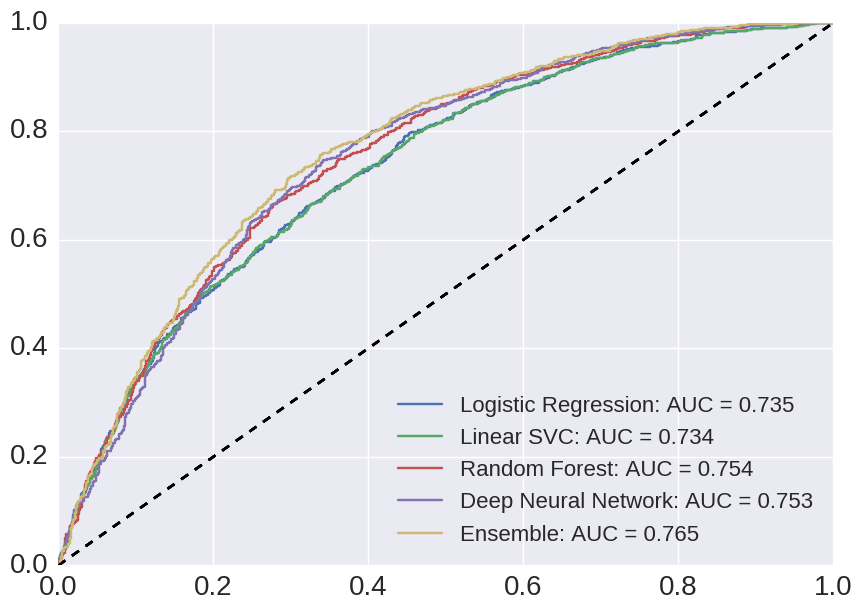

In [179]:
plt.subplots(figsize=(10,7))
for i in range(5):
    plot_roc_curve(y_val, probs[i],names[i])

#plt.savefig(FIGURE_DIR+'ROC.svg',transparent=True,format='svg')

### Feature Importance

In [27]:
if type(clf._final_estimator) == RandomForestClassifier:
    fx_imp = abs(pd.Series(clf._final_estimator.feature_importances_,index=list_of_features))
else:
    fx_imp = abs(pd.Series(clf._final_estimator.coef_[0],index=list_of_features))
fx_imp /= fx_imp.max() # normalize
fx_imp.sort_values(ascending=0,inplace=True)

In [28]:
colors = []
for name in fx_imp.index:
    if name in aa_features:
        colors.append('deepskyblue')
    elif name in disorder_features:
        colors.append('darkorange')
    elif name in phys_features:
        colors.append('green')
    elif name in rna_features:
        colors.append('brown')
    elif name in ss_features:
        colors.append('mediumorchid')
    else:
        sys.exit('Error: Feature not recognized')


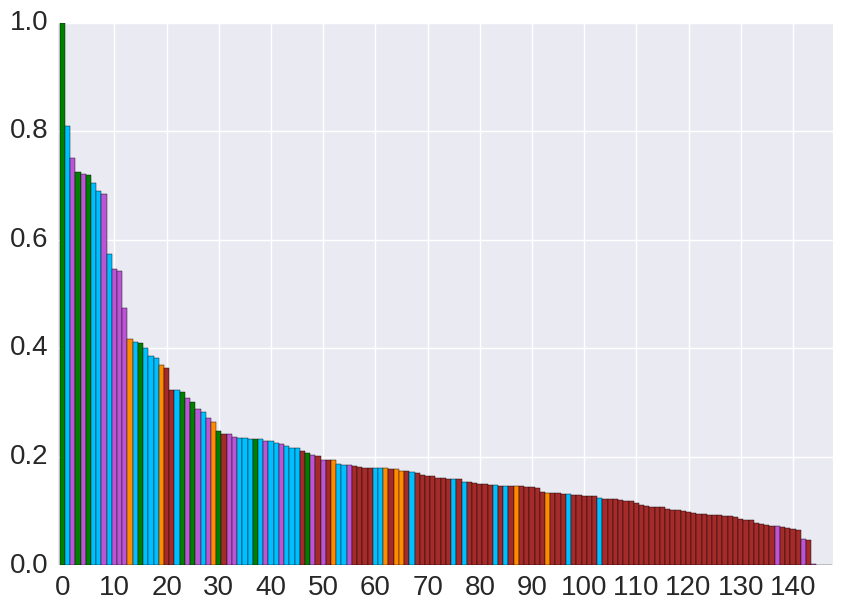

In [29]:
ax = fx_imp.plot(kind='bar', color=colors,width=1,figsize=(10,7));
plt.xticks(range(0,len(fx_imp),10),range(0,len(fx_imp),10),rotation='horizontal');

#plt.savefig(FIGURE_DIR+'feature_importance.svg',transparent=True,format='svg')
None

In [30]:
fx_imp_short = fx_imp.sort_values(ascending=0)[:10]
print fx_imp_short.index

Index([u'bio_pI', u'list_comp_L', u'ss_ext', u'bio_gravy', u'ss8_ext',
       u'avg_charge', u'frac_polar', u'list_comp_Y', u'acc_hydrophobic_in',
       u'frac_hydrophobic'],
      dtype='object')


In [31]:
new_index = ['Isoelectric Point',
             'Grand Average Value of Hydropathy',
             '% Leucine',
             'Average Charge',
             'Extended Secondary Structure (8-letter)',
             '% Polar Residues',
             '% Hydrophobic Solvent-Inaccessible Residues',
             'Extended Secondary Structure (3-letter)',
             '% Tyrosine',
             'Average GRAVY of Solvent-Inaccessible Residues',             
             ] 
fx_imp_short.index = new_index

In [32]:
fx_imp.sort_values(ascending=0)[:20]

bio_pI                  1.000000
list_comp_L             0.808829
ss_ext                  0.751383
bio_gravy               0.725008
ss8_ext                 0.721899
avg_charge              0.719444
frac_polar              0.705136
list_comp_Y             0.689879
acc_hydrophobic_in      0.684721
frac_hydrophobic        0.574066
ss_helix                0.546222
in_gravy                0.543260
ss8_helix               0.473890
ronn_avg                0.417491
frac_negative           0.411870
bio_mW                  0.409624
frac_uncharged_polar    0.399647
frac_aliphatic          0.385967
list_comp_P             0.382736
disembl_COILS_frac      0.369017
dtype: float64

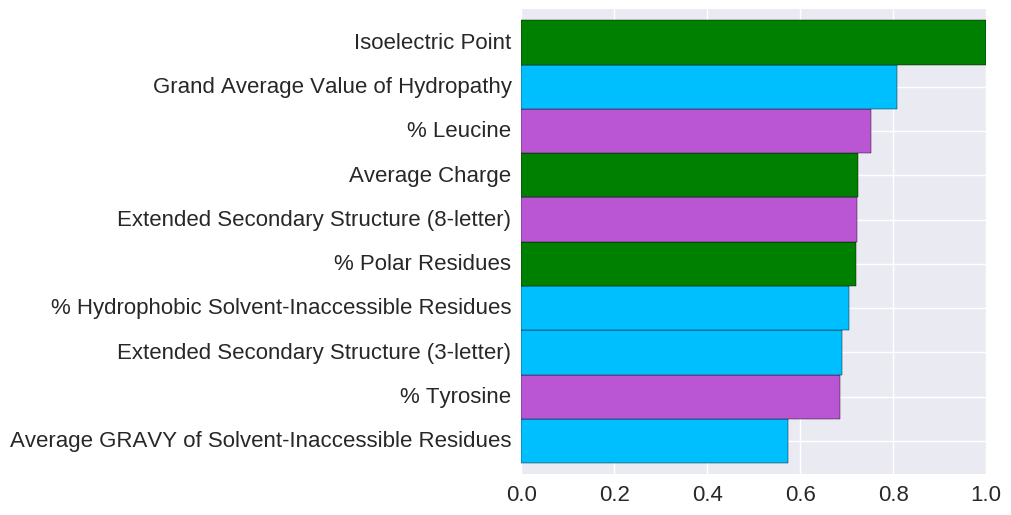

In [33]:
fig = plt.figure(figsize=(6,6))

fx_imp_short.sort_values(ascending=1)[-10:].plot(kind='barh', color=list(reversed(colors[:10])),fontsize=16,width=1)
#plt.savefig(FIGURE_DIR+'feature_importance10.svg',transparent=True,format='svg')

### Final evaluation on Test Set

In [34]:
print "Final Score on Validation Set: %0.2f%%" % (100 * clf.score(X_val, y_val))

Final Score on Validation Set: 68.51%


[[ 0.67  0.34]
 [ 0.3   0.71]]


/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


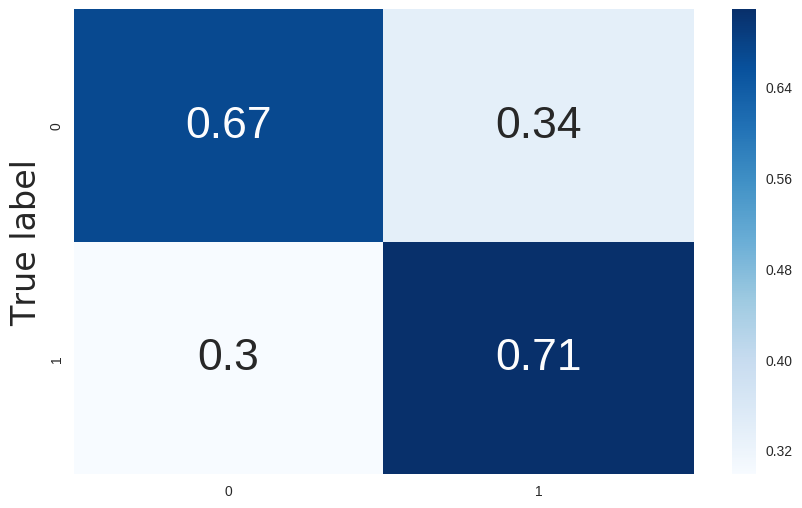

In [35]:
from sklearn.metrics import confusion_matrix
from decimal import Decimal, ROUND_DOWN, ROUND_UP
from copy import deepcopy

import seaborn as sns
sns.set(style="white")
plt.rc("figure", figsize=(10, 6))
np.set_printoptions(precision=4)

predicted = clf.predict(X_val)
cm = confusion_matrix(y_val, predicted)

cm2 = deepcopy(cm)
a = Decimal(np.true_divide(cm[0,0], cm.sum(axis=1)[0])).quantize(Decimal('.01'), rounding=ROUND_UP)
b = Decimal(np.true_divide(cm[0,1], cm.sum(axis=1)[0])).quantize(Decimal('.01'), rounding=ROUND_UP)
c = Decimal(np.true_divide(cm[1,0], cm.sum(axis=1)[1])).quantize(Decimal('.01'), rounding=ROUND_UP)
d = Decimal(np.true_divide(cm[1,1], cm.sum(axis=1)[1])).quantize(Decimal('.01'), rounding=ROUND_UP)
cm2 = np.matrix([[a, b],[c, d]])

#cm_normalized = cm.astype(np.float64) / cm.sum(axis=1)
cm_normalized = cm2.astype(np.float64) 



print cm_normalized
axis_font = {'fontname':'Arial', 'size':'24'}
sns.heatmap(cm_normalized, annot=True,  fmt='', cmap='Blues',annot_kws={"size": 32})
plt.ylabel('True label',**axis_font)

### Ensemble Model

In [85]:
ens1 = clfs[1].predict_proba(X_test)[:,1]

In [84]:
ens2 = np.loadtxt(DATA_DIR + 'final_nn_test.txt',delimiter=',')

In [94]:
ens3 = clfs[0].predict_proba(X_test)[:,1]

In [97]:
ens_pred = np.round(np.mean(np.vstack((ens1,ens2)),axis=0))

In [39]:
num_test = len(y_test)
res = np.zeros((4,num_test))
for i,clf in enumerate(clfs):
    res[i,:] = clf.predict(X_test).reshape((1,num_test))

## Deep learning
res[3,:] = np.loadtxt(DATA_DIR + 'final_nn_test.txt',delimiter=',')

In [55]:
def accuracy(pred,actual):
    return 1 - np.true_divide(np.sum(abs(pred-actual)),len(actual))

In [59]:
print 'Linear Model:', accuracy(res[0,:],y_test.astype(int))
print 'Random Forest:', accuracy(res[1,:],y_test.astype(int))
print 'SVM:', accuracy(res[2,:],y_test.astype(int))
print 'Neural Network:', accuracy(res[3,:],y_test.astype(int))

Linear Model: 0.668780415868
Random Forest: 0.671877304232
SVM: 0.666273411001
Neural Network: 0.688246571302


In [98]:
accuracy(ens_pred,y_test.astype(int))

0.69724229464680731

### Get values for figure 5C

In [85]:
DF_figure = DF_prest.copy()

In [86]:
DF_figure.loc[:,'prob'] = clf.predict_proba(DF_figure[list_of_features])[:,1]
DF_figure.loc[:,'expr_val'] = [1 if exp > min_expressed else 0 if exp < max_not_expressed else np.nan for exp in DF_figure.conc_cf]

In [87]:
tmp_DF = DF_figure[['prest_id','uniprot_id','conc_cf','prob','expr_val','aa_seq']].sort_values('uniprot_id')
for name,group in DF_figure.groupby('uniprot_id'):
    if len(group) > 3:
        if all(pd.notnull(group.expr_val)):
            if all((group.prob > 0.5) == (group.expr_val)):
                break
                print name

In [88]:
tmp_DF[tmp_DF['uniprot_id'] == 'Q9BZ81'].prob.values

array([ 0.6977,  0.548 ,  0.6437,  0.2942])

In [89]:
tmp_DF[tmp_DF['uniprot_id'] == 'Q9BZ81'][['prest_id','expr_val','conc_cf','prob']]

,prest_id,expr_val,conc_cf,prob
34474,3790445,1,8.2100,0.697729
34473,3790444,NaN,6.5800,0.548046
14675,2760371,1,8.1595,0.643724
14676,2760372,0,2.3404,0.294224


In [90]:
tmp_DF.head()

,prest_id,uniprot_id,conc_cf,prob,expr_val,aa_seq
936,1840225,A0A024QZP7,5.180,0.289444,NaN,VPSTAIREISLLKELRHPNIVSLQDVLMQDSRLYLIFEFLSMDLKK...
544,1450167,A0A024R0Y4,10.595,0.518941,1,RYPKEVQDLYETMRRFARIVGPVEHDKFIESHALEFELRREIKRLQ...
32597,3720663,A0A024R0Y4,5.190,0.418431,NaN,IIRDHGLINLRKFQLMERRYPKEVQDLYETMRRFARIVGPVEHDKF...
32596,3720662,A0A024R0Y4,6.890,0.559033,NaN,EVLQYIQDSSACQQWLRRQADIDSGLSPSIPMASNSGRRSAPPLNL...
32595,3720661,A0A024R0Y4,8.950,0.769142,1,MDRLGPFSNDPSDKPPCRGCSSYLMEPYIKCAECGPPPFFLCLQCF...
